# BirdGAN 

## TODO

- [ ] Separate configuration to external file
- [ ] Restructure and organize code to one ipynb file
- [ ] Extract code from ipynb to python file to run on server
- [ ] Request for more data (total should be ~10-20 files)
- [ ] Hand-label scalogram files in GIMP and extract ranges

In [50]:
# general imports
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

# wave processing
import wave
import struct

# keras imports
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, LeakyReLU, Reshape, Conv2DTranspose
from keras.preprocessing.image import ImageDataGenerator

# HMM
from hmmlearn import hmm

# Configuration

In [2]:
# constants / config

# data directory
data_dir = os.getcwd() + '/data'

# 1 second pixel width
SEC = 128

# random number generator seed
SEED = 42

# Data Pre-processing

## Loading and standardizing

In [3]:
# load scalograms from directory
def load_scal(data_dir):
    images = []
    # append images to list
    for filename in os.listdir(data_dir):
        img = Image.open(os.path.join(data_dir, filename))
        images.append(img)
    
    # convert images to np array
    scal = [np.array(img) for img in images]
    
    return scal

scalograms = load_scal(data_dir)

In [4]:
# type cast to float32
# standardize to mean +- 3 std and clip
def standardize(scalograms):
    #scalograms = [(s.astype(np.float32) - 127.5)/127.5 for s in scalograms]
    scalograms = [s.astype(np.float32) for s in scalograms] # type cast to np.float32
    scalograms = [(s - np.mean(s)) / np.std(s) for s in scalograms] # standardize
    scalograms = [np.clip(s, np.mean(s) - 3*np.std(s), np.mean(s) + 3*np.std(s)) for s in scalograms] # clip 
    
    for s in scalograms:
        print('min: %f, max: %f, mean: %f, std: %f' % (np.min(s), np.max(s), np.mean(s), np.std(s)))
        
#     norm = plt.Normalize(-1,1) # normalization for pyplot    
        
    return scalograms
        
std_scalograms = standardize(scalograms)

min: -3.000055, max: 0.148558, mean: 0.053217, std: 0.398102
min: -3.000154, max: 0.182846, mean: 0.064368, std: 0.506115


In [5]:
# delete first 10000 columns of sc0
std_scalograms[0] = std_scalograms[0][:, 10500:]

## Select frames from each scalogram in directory

Each frame range of 700 pixels contains one bird call.

In [6]:
sc0 = std_scalograms[0]
sc1 = std_scalograms[1]

In [7]:
sc0_frames = [
    [22000, 22700], 
    [23000, 23700], 
    [23700, 24400], 
    [24400, 25100], 
    [24800, 25500], 
    [25500, 26200],
    [47400, 48100], 
    [48200, 48900], 
    [48900, 49600], 
    [49500, 50200], 
    [50000, 50700], 
    [50800, 51500],
    [71700, 72400], 
    [72500, 73200], 
    [73200, 73900], 
    [74900, 75600],
    [98800, 99500],
    [99800, 100500], 
    [100400, 101100], 
    [100900, 101600], 
    [101400, 102100], 
    [102200, 102900], 
    [125000, 125700], 
    [126000, 126700], 
    [126500, 127200], 
    [127000, 127700], 
    [127700, 128400], 
    [128200, 128900], 
]

len(sc0_frames)

28

In [8]:
sc1_frames = [
    [10500,11200],
    [11600,12300],
    [12700,13400],
    [13900,14600],
    [15100,15800],
    [16400,17100],
    [17700,18400],
    [18900,19600],
    [20100,20800],
    [21200,21900],
    [22300,23000],
    [23500,24200],
    [24800,25500],
    [25900,26600],
    [27100,27800],
    [28100,28800],
    [33500,34200],
    [34500,35200],
    [35600,36300],
    [36700,37400],
    [38000,38700],
    [39200,39900],
    [40400,41100],
    [41600,42300],
    [42800,43500],
    [43900,44600],
    [45100,45800],
    [46200,46900],
    [48600,49300],
    [49700,50400],
    [50900,51600],
    [52100,52800],
    [60600,61300],
    [62500,63200],
    [63700,64400],
    [68600,69300] # this is enough for now.
]

len(sc1_frames)

36

## Plot selected calls

In [16]:
def plot_frames(scal, frames):
    r = int(math.sqrt(len(frames))) # r x (r+1) subplots
    plt.figure(figsize=(50,50))
    for i in range(len(frames)):
        plt.subplot(r+1,r,i+1)
        plt.imshow(scal[:, frames[i][0]:frames[i][1]], cmap='inferno')
    plt.show()

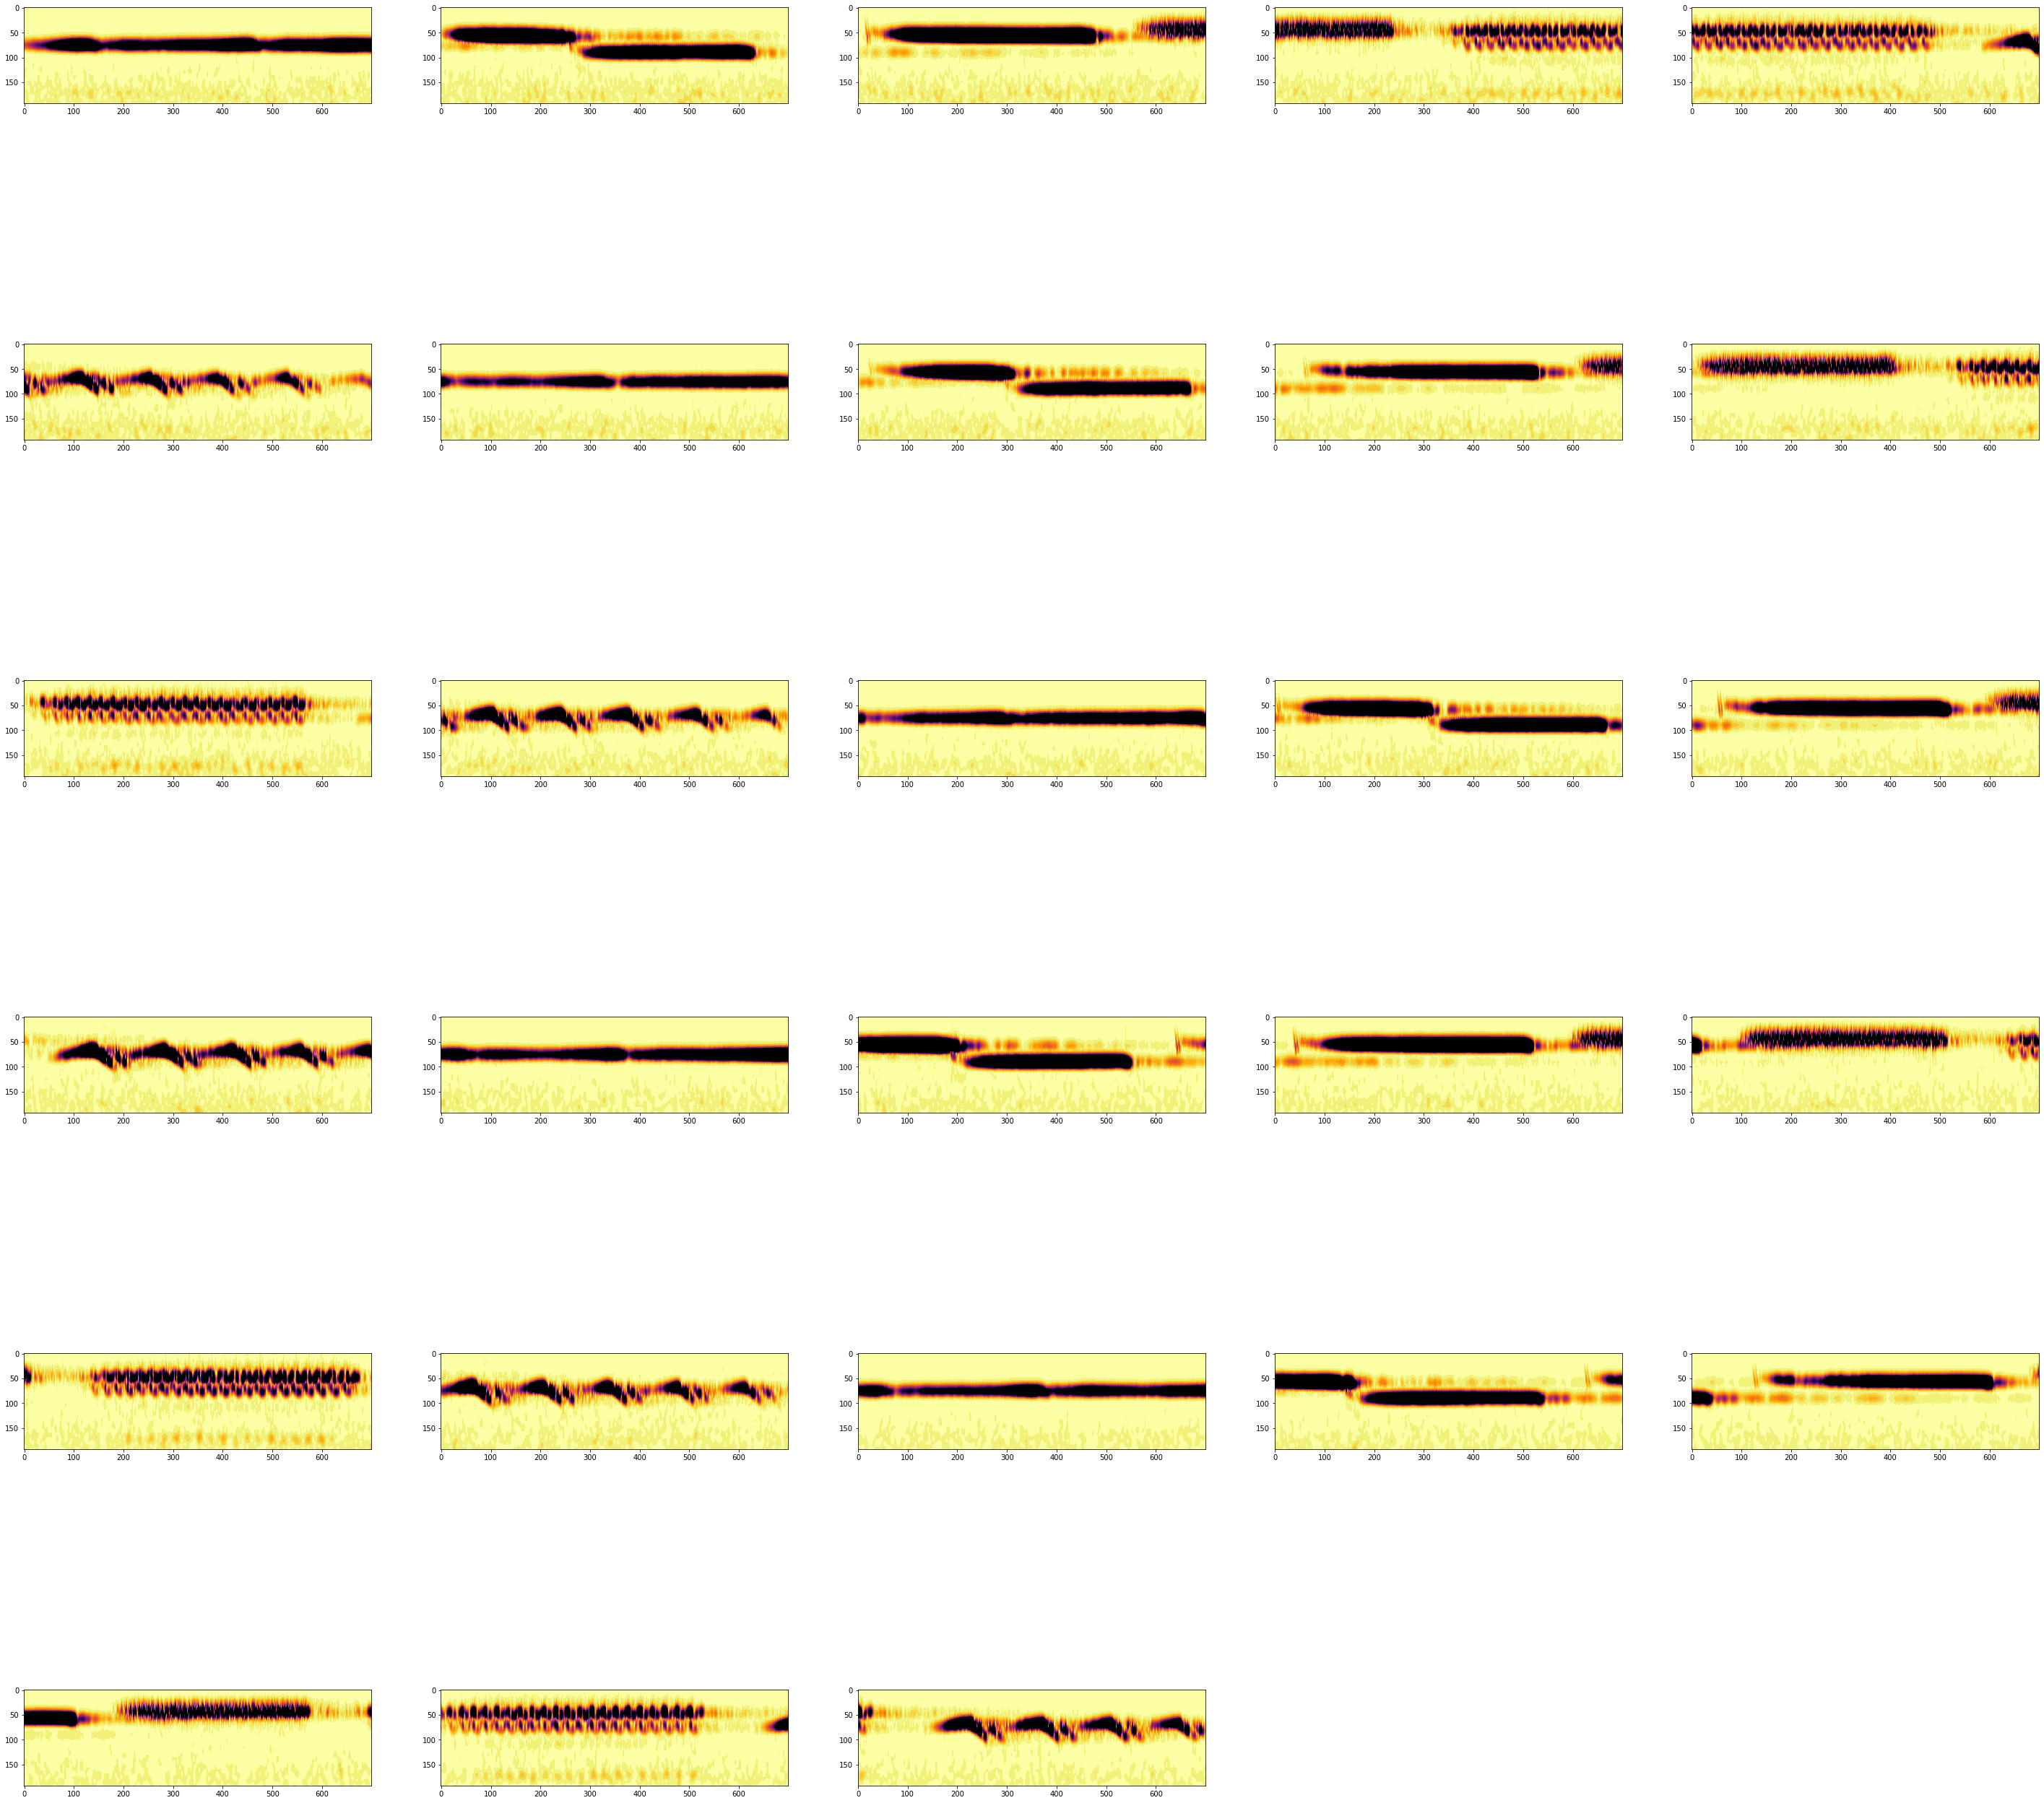

In [17]:
plot_frames(sc0, sc0_frames)

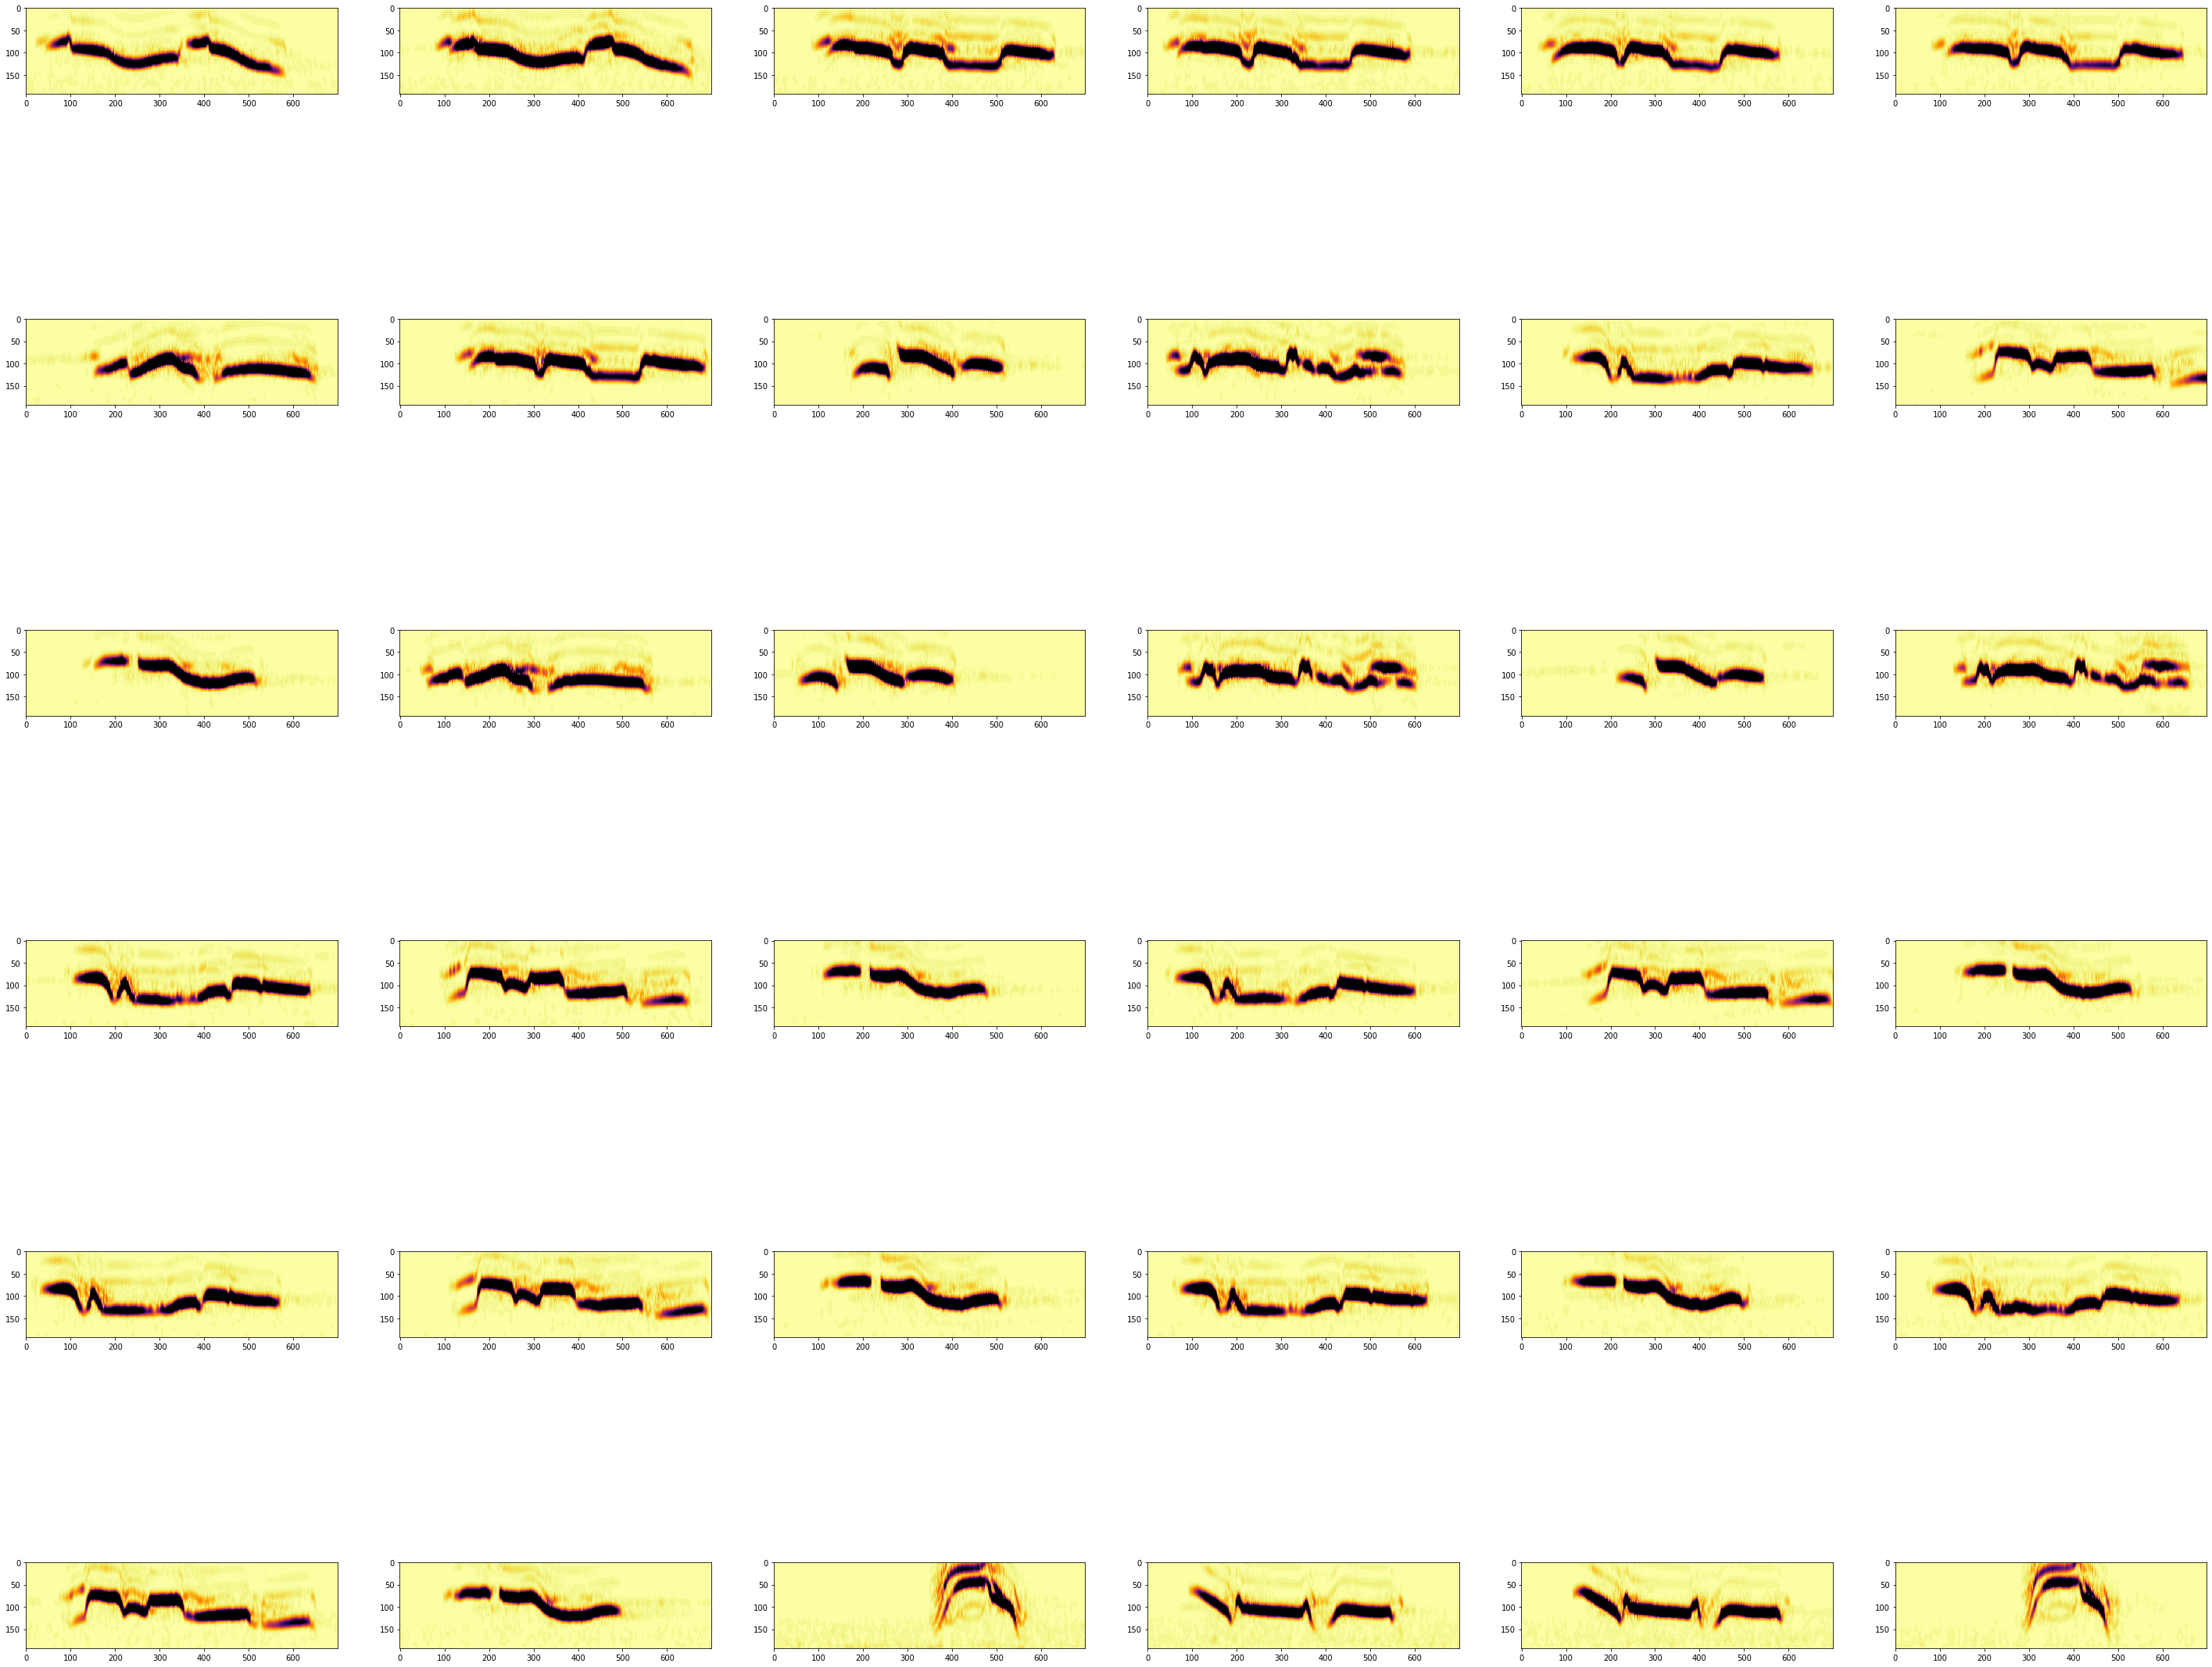

In [18]:
plot_frames(sc1, sc1_frames)

In [ ]:
plt.figure(figsize=(50,100))
plt.imshow(sc1[:, 70100:70900], cmap='inferno')
plt.show()

In [ ]:
frames = [
    sc0_frames,
    sc1_frames
]

## Wave file processing -- picking out silent frames

In [21]:
robin = wave.open('./recordings/ml-american-robin.wav', 'r')
frame_n = robin.getnframes()

In [22]:
def silent_frames(w,threshold, x=0, y=-1, verbose=True):
    """
    Finds the silent frames of wave file
    
    Arguments:
        w - wave file
        threshold - threshold value for sound intensity
    
    Returns:
        frame_val - list of all significant (non-silent) frames
        s_frame_val - list of silent frames
    """
    # start at beginning of file
    w.rewind()
   
    #init frame arrays
    init_size = w.getnframes()
    
    frames = np.empty(init_size)
    s_frames = np.empty(init_size)
    
    frames_n=0
    s_frames_n = 0
    
    if y == -1:
        y = init_size
    
    
    
    for i in range(w.getnframes()):
        # read a single frame and advance to next frame
        current_frame= w.readframes(1)
        
        if w.tell() >= x:

            # check for silence
            silent = True
            # wave frame samples are stored in little endian**
            # this example works for a single channel 16-bit per sample encoding
            unpacked_signed_value = struct.unpack("<h", current_frame) # *
            if abs(unpacked_signed_value[0]) > threshold:
                silent = False

            if silent:
                s_frames[s_frames_n] = w.tell()
                s_frames_n +=1
                if verbose:
                    print ("Frame %s is silent." % w.tell())
                    print ("silence found at second %s" % (w.tell()/w.getframerate()))
            else:
                frames[frames_n] = w.tell()
                frames_n +=1
                if verbose:
                    print ("Frame %s is not silent." % w.tell())
                
            if w.tell() == y:
                break

    frames = np.resize(frames,frames_n)
    s_frames = np.resize(s_frames,s_frames_n)
    
    print(frames_n)            
    return frames, s_frames        

In [23]:
frames, s_frames = silent_frames(robin, 50, verbose=False) 

2536701


Note:
> 2003 pixels on png scalogram == 44100 frames on audio file 
>
> Approximately 22 frames per pixel

In [24]:
def frame_to_pixel(f):
    return f * 2003 / 44100

In [25]:
def pixel_to_frame(p):
    return p * 44100 / 2003 

In [75]:
def get_silent_pixels(silent_frames, start, end):
    """
    gets silent pixels in pixel range [start,end]
    
    Arg:
        silent_frames - list of silent frames
        start - start frame
        end - end frame
        
    Return:
        silent_pixels - list of silent pixels from [start,end]
    """
    silent_pixels = [frame_to_pixel(x) for x in silent_frames]
    silent_pixels = [(int)(x) for x in silent_pixels if x > start and x < end]
    return list(set(silent_pixels))

In [76]:
s_pixels = get_silent_pixels(s_frames, 0, 20000)
# s_pixels = get_silent_pixels(s_frames, 20000,40000)

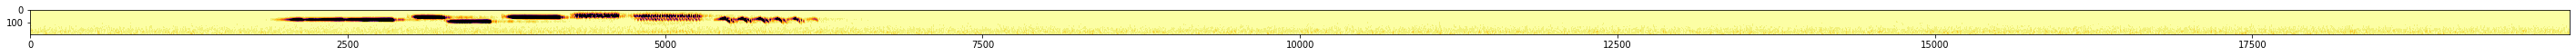

In [40]:
# plot of scalogram 0 -- white-crowned sparrow
plot_frames(sc0, [[20000,40000]])

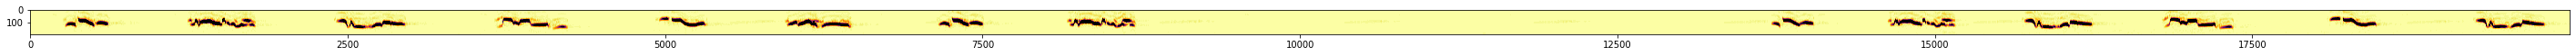

In [41]:
# plot of scalogram 1 -- american robin
plot_frames(sc1, [[20000,40000]])

In [42]:
sc1_silent = np.copy(sc1) # copy of sc0 
for x in np.array(s_pixels):
    sc1_silent[:,x] = np.min(sc1_silent) * np.ones(193)

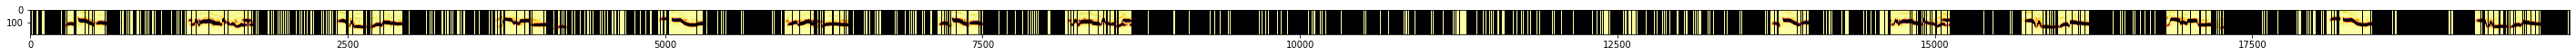

In [43]:
plot_frames(sc1_silent, [[20000,40000]])

### Hidden Markov Model

In [77]:
def make_obs_list(silent_pixels, start, end):
    """
    makes a (end-start) length list of observations based on silent_pixels.
    Note:
            0 = silent
            1 = heard
    
    Arg:
        silent_pixels - list of silent pixels
        start - start pixel
        end - end pixel
    
    Return:
        obs - list of observations based on silent_pixels
    """
    obs = np.ones(end-start) # initialize with ones
    obs[[x - (end-start) for x in s_pixels]] = 0 # set silent pixels to 0
    obs = np.array([[int(x)] for x in obs]) # restructure for hmmlearn input
    
    return obs

In [78]:
# obs_list = make_obs_list(s_pixels, 20000, 40000)
obs_list = make_obs_list(s_pixels, 0, 20000)

### Multinomial HMM with 2 components (silent/not silent)

`obs_list`: list of observations
- `0`: silent
- `1`: not silent

`Z`: list of most likely states (output of viterbi algorithm)
- `0`: no call
- `1`: call

In [79]:
obs_list

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [83]:
Z

array([0, 0, 0, ..., 0, 0, 0])

In [81]:
model = hmm.MultinomialHMM(n_components=2) # discrete multinomial HMM
model.fit(obs_list)

MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=2,
               n_iter=10, params='ste',
               random_state=<mtrand.RandomState object at 0x7f23facaf798>,
               startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
               verbose=False)

In [97]:
# make prediction
Z = model.predict(obs_list)
Z # Z = most likely sequence of hidden states that emitted observations in obs_list

array([0, 0, 0, ..., 0, 0, 0])

In [84]:
model.startprob_

array([0.99753147, 0.00246853])

In [96]:
model.transmat_ = [[0.98,0.02],[0.01,0.99]]
model.transmat_

[[0.98, 0.02], [0.01, 0.99]]

In [90]:
model.emissionprob_ = np.array([[0.6,0.4],[0.4,0.6]])
model.emissionprob_

array([[0.6, 0.4],
       [0.4, 0.6]])

In [94]:
def test_preds(seq, sc, start, end):
    """
    test_preds plots the scalogram with its silent pixels blacked out
    
    Arg:
        seq - sequence of most likely states of call/nocall
        sc - scalogram
        start - start index
        end - end index
        
    Return:
        None
    """
#     end = len(pixels)
    
    hmm_sc = np.copy(sc[:,start:end]) # copy scalogram in range start:end
    
    for i,p in enumerate(seq):
        if not p: # if silent
            hmm_sc[:,i] = np.min(hmm_sc) * np.ones(hmm_sc.shape[0])
        
    plt.figure(figsize=(75,150))
    plt.imshow(hmm_sc, cmap='inferno')
    plt.show()

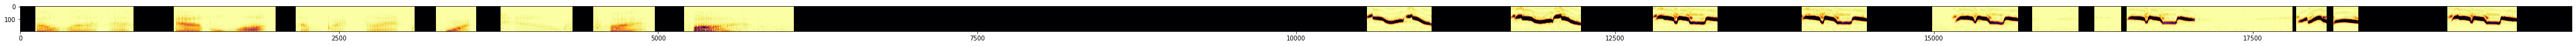

In [98]:
test_preds(Z, sc1, 0, 20000)

# 2-way Classifier

In [ ]:
def make_dataset(frames, scalograms):
    
    x = [] # data
    y = [] # label
    
    for i,(f,s) in enumerate(zip(frames, scalograms)):
        for [a,b] in f:
            frame = np.array(s[:, a:b])
#             print(frame.shape)
            x.append(frame)
            y.append(i)
            
    # convert to np array
    x = np.array(x)
    y = np.array(y)
    
    return x,y
                
X, y = make_dataset(frames, std_scalograms)

In [ ]:
# shuffle dataset in unison
p = np.random.RandomState(seed=SEED).permutation(len(X))

X = X[p]
y = y[p]

In [ ]:
x_train, x_test = np.split(X, [-4])
y_train, y_test = np.split(y, [-4])

In [ ]:
x_train = x_train.reshape((-1, 193, 700, 1))
x_test = x_test.reshape((-1, 193, 700, 1))

In [ ]:
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False)

In [ ]:
datagen.fit(x_train)

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), strides=1, activation='relu', input_shape=(193,700,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
epochs = 5

In [ ]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=10), steps_per_epoch=len(x_train)/10, epochs=epochs)

In [ ]:
plt.figure(figsize=(20,10))
for i,s in enumerate(x_test):
    plt.subplot(2,2,i+1)
    plt.imshow(s.reshape(193, 700), cmap='inferno')
plt.show()

In [ ]:
y_test

In [ ]:
model.evaluate(x_test,y_test)

# GAN

In [ ]:
def make_datasets(frames, scalograms):
    # make sure the number of scalograms is the same as the number of sets of selected frames
#     assert len(frames) == len(scalograms)

    dataset = [] # full dataset
    
    for [x,y] in frames:
        dataset.append(scalograms[:, x:y])

    return np.array(dataset)

In [ ]:
dataset = make_datasets(sc1_frames, sc1)
print(dataset.shape)

In [ ]:
# data generator

# reshape to channel 1
dataset = dataset.reshape(-1,  193, 700, 1)

datagen = ImageDataGenerator()
datagen.fit(dataset)

In [ ]:
193 * 175

In [ ]:
135100 / 4 / 193

In [ ]:
33775 / 

## GAN architecture

In [ ]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

In [ ]:
def build_generator():
    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

In [ ]:
def build_discriminator():

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [ ]:
img_rows = 193
img_cols = 700
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
validity = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
def sample_images(self, epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/%d.png" % epoch)
    plt.close()

def train(X_train, epochs, batch_size=32, sample_interval=50):

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Generate a batch of new images
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Train the generator (to have the discriminator label samples as valid)
        g_loss = combined.train_on_batch(noise, valid)

        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            sample_images(epoch)

In [ ]:
train(X_train=dataset, epochs=100, batch_size=16, sample_interval=1)

In [ ]:
# generator
gen = Sequential()

gen.add(Dense(193*175, input_dim=193))
gen.add(LeakyReLU(alpha=0.2))
gen.add(Reshape((193,175,1)))

gen.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
gen.add(LeakyReLU(alpha=0.2))

gen.summary()

# gen.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
# gen.add(LeakyReLU(alpha=0.2))

# gen.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
# gen.add(Activation('tanh'))

# gen.summary()
# gen.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# discriminator
disc = Sequential()

disc.add(Conv2D(128, kernel_size=3, strides=2, padding='same', input_shape=(193,700,1)))
disc.add(LeakyReLU(alpha=0.2))

disc.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
disc.add(LeakyReLU(alpha=0.2))

disc.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
disc.add(LeakyReLU(alpha=0.2))

disc.add(Conv2D(32, kernel_size=3, strides=2, padding='same'))
disc.add(LeakyReLU(alpha=0.2))

disc.add(Conv2D(16, kernel_size=3, strides=2, padding='same'))
disc.add(LeakyReLU(alpha=0.2))

disc.add(Dropout(0.3))

disc.add(Flatten())

disc.add(Dense(1, activation='sigmoid'))

disc.summary()
disc.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])